In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [3]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend();

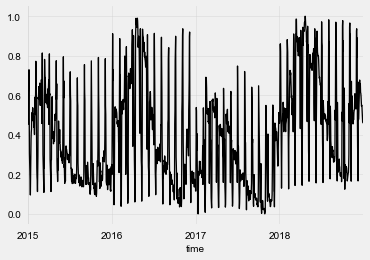

In [4]:
df = pd.read_csv('energy_dataset.csv', delimiter=",")
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time']= df.time.dt.tz_localize(None)
df_day_avg = df.groupby(df['time'].astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(filler.transform(
    TimeSeries.from_dataframe(df_day_avg, 'time', ['generation hydro run-of-river and poundage'])
))
series.plot()

In [5]:
train, val = series.split_after(pd.Timestamp('20170901'))

### General model

In [6]:
model_nbeats = NBEATSModel(
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    input_length=30,
    output_length=7,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800
)

In [7]:
model_nbeats.fit(
    training_series=train,
    val_training_series=val,
    verbose=True
)

Training loss: 0.0230, validation loss: 0.0342


[2020-11-04 15:59:09,089] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.



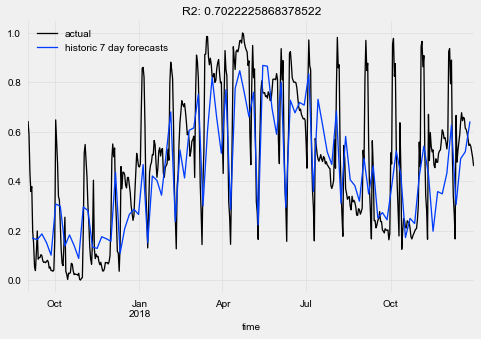

In [8]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    use_full_output_length=True,
    last_points_only=True,
    verbose=True
)
display_forecast(pred_series, series['0'], '7 day', start_date=pd.Timestamp('20170901'))

### Interpretable model

In [9]:
model_nbeats = NBEATSModel(
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    input_length=30,
    output_length=7,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800
)

In [10]:
model_nbeats.fit(
    training_series=train,
    val_training_series=val,
    verbose=True
)

Training loss: 0.0485, validation loss: 0.0466


[2020-11-04 15:59:38,082] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.



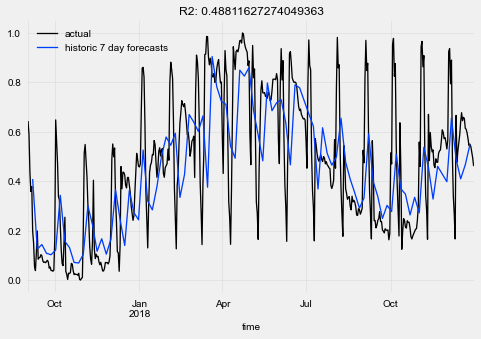

In [11]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    use_full_output_length=True,
    last_points_only=True,
    verbose=True
)
display_forecast(pred_series, series['0'], '7 day', start_date=pd.Timestamp('20170901'))